<a href="https://colab.research.google.com/github/Christian-rojas1/valorador_empresas_usa/blob/main/valorador_empresas_usa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# librerias y paquetes necesarios
!pip install yfinance
!pip install googletrans==4.0.0-rc1
from google.colab import files
import yfinance as yf
import pandas as pd
from google.colab import files
import numpy as np
import math
from openpyxl import load_workbook
import matplotlib.pyplot as plt
from googletrans import Translator
from openpyxl.drawing.image import Image
from io import BytesIO
import seaborn as sns
import requests


In [ ]:
#NASDAQ=^IXIC
#S&P500=^GSPC

simbolo = input("Ingrese la accion que quiere valorar: ")
simbolo2 = input("Ingrese el benchmark para comparar: ")

Ingrese la accion que quiere valorar: AAPL
Ingrese el benchmark para comparar: ^GSPC


In [ ]:
diasatras1=int(input("Ingrese numero de dias atras que quiere ver: "))

Ingrese numero de dias atras que quiere ver: 256


##VALORACION ESTADISTICA

In [ ]:
hoy = pd.Timestamp.now().date()
finicio = (hoy - pd.DateOffset(years=5)).strftime("%Y-%m-%d")
ffin = hoy.strftime("%Y-%m-%d")

ticker_object = yf.Ticker(simbolo)
pcaccio= ticker_object.history(start=finicio,end=ffin)
pcaccio.index = pcaccio.index.tz_convert(None).date

ticker_object2 = yf.Ticker(simbolo2)
pcaccio2= ticker_object2.history(start=finicio,end=ffin)
pcaccio2.index = pcaccio2.index.tz_convert(None).date

pcaccion = pcaccio["Close"]
pcaccion2 = pcaccio2["Close"]


bdatos = pd.concat([pcaccion, pcaccion2], axis=1)
bdatos.columns = [simbolo, simbolo2]
bdatos = bdatos.round(3)
bdatos = bdatos.dropna()
bdatos['R1']=(((bdatos[simbolo]/bdatos[simbolo].shift(1))-1)).round(3)
bdatos['R2']=(((bdatos[simbolo2]/bdatos[simbolo2].shift(1))-1)).round(3)

#logaritmos
bdatos['LNR1']=(np.log(bdatos[simbolo])).round(3)
bdatos['LNR2']=(np.log(bdatos[simbolo2])).round(3)

#Base 100
bdatos["ACCION B100"]=""
bdatos.iloc[0, 6] = 100
for i in range(1, len(bdatos)):
  bdatos.iloc[i, 6] = (bdatos.iloc[i - 1, 6] )* (1 + (bdatos.iloc[i, 2]) )
  bdatos.iloc[i, 6]= bdatos.iloc[i, 6].round(3)

bdatos["INDICE B100"]=""
bdatos.iloc[0, 7] = 100
for i in range(1, len(bdatos)):
  bdatos.iloc[i, 7] = (bdatos.iloc[i - 1, 7] )* (1 + (bdatos.iloc[i, 3]) )
  bdatos.iloc[i, 7]= bdatos.iloc[i, 7].round(3)

# prompt: sacar maximo y minimo de BABA en bdatos

max_accion = bdatos[simbolo].max()
min_accion = bdatos[simbolo].min()
mean_accion = bdatos[simbolo].mean().round(3)
ultimoprecio = bdatos[simbolo].iloc[-1]
numdatos = bdatos[simbolo].count()
nclases =(math.sqrt(numdatos))
nclases = round(nclases, 3)
eoptimista= (max_accion/ultimoprecio-1).round(3)
eneutral= (mean_accion/ultimoprecio-1).round(3)
epesimista= (min_accion/ultimoprecio-1).round(3)
rango = ((max_accion-min_accion)/nclases).round(3)

datshisto2=[[max_accion,min_accion,mean_accion,ultimoprecio,numdatos,nclases,eoptimista,eneutral,epesimista,rango]]
datshisto2 = pd.DataFrame(datshisto2, columns=['maximo', 'minimo', 'promedio', 'ultimo_precio', 'numero_datos', 'nclases', 'escenario_optimista', 'escenario_neutral', 'escenario_pesimista', 'rango'])

numhistograma=[0]
for i in numhistograma:
  if i< nclases:
    numhistograma.append(i+1)
grupos_histograma = []
valor_inicial = min_accion
for i in numhistograma:
  grupos_histograma.append(valor_inicial)
  valor_inicial += rango
bdatoshistograma = pd.concat([pd.DataFrame(numhistograma), pd.DataFrame(grupos_histograma)], axis=1)
bdatoshistograma.columns = ['Num', 'Grupos']

#frecuencia
frecuencias = bdatos[simbolo].value_counts(bins=bdatoshistograma['Grupos'])
frecuencias.sort_index(inplace=True)

#Unir frecuencia a base de datos
bdatoshistograma = pd.concat([bdatoshistograma, frecuencias.to_frame().reset_index()], axis=1)
bdatoshistograma.columns = ['Num', 'Grupos', 'Intervalo', 'Frecuencia']

#Probabilidad
bdatoshistograma['Probabilidad%']=""
for i in range(0, len(bdatoshistograma)):
   bdatoshistograma.iloc[i, 4] = (((bdatoshistograma.iloc[i, 3] )/numdatos) ).round(4)


#Probabilidad ACUM
bdatoshistograma['Probabilidad Acum %']=bdatoshistograma.iloc[0,4]
for i in range(1, len(bdatoshistograma)):
   bdatoshistograma.iloc[i, 5] = ((bdatoshistograma.iloc[i-1, 5] )+bdatoshistograma.iloc[i, 4] ) .round(4)


#UBICACION
bdatoshistograma['UBICACIÓN']=""
for i in range(1, len(bdatoshistograma)):
  if bdatoshistograma.iloc[i-1, 1]< ultimoprecio and bdatoshistograma.iloc[i, 1]> ultimoprecio:
       bdatoshistograma.iloc[i, 6] = 'Actual'

percentil=[0,0.01,0.05,0.1,0.25,0.50,0.75,0.90,0.95,0.99,1]
percentil_accion = bdatos[simbolo].quantile(percentil)
percentil_accion_df = pd.DataFrame(percentil_accion)
percentil_accion_df['Ubicacion']=""
for i in range(0, len(percentil_accion_df)):
  if percentil_accion_df[simbolo].iloc[i-1]<ultimoprecio and percentil_accion_df[simbolo].iloc[i]> ultimoprecio:
    percentil_accion_df.iloc[i, 1] = 1


#regresion cambiar los dias segun se requiera (estan ultimos 720 dias.....)
rendimientolnaccion1=bdatos['LNR1'].iloc[-diasatras1:]
rendimientolnaccion2=bdatos['LNR1'].iloc[-360:]
rendimientolnaccion3=bdatos['LNR1'].iloc[-180:]
rendimientolnaccion4=bdatos['LNR1'].iloc[-90:]
rendimientolnaccion5=bdatos['LNR1'].iloc[-30:]


rendimientolnindice1=bdatos['LNR2'].iloc[-diasatras1:]
rendimientolnindice2=bdatos['LNR2'].iloc[-360:]
rendimientolnindice3=bdatos['LNR2'].iloc[-180:]
rendimientolnindice4=bdatos['LNR2'].iloc[-90:]
rendimientolnindice5=bdatos['LNR2'].iloc[-30:]

#correlaciones
correlacion1 = rendimientolnaccion1.corr(rendimientolnindice1)
correlacion2 = rendimientolnaccion2.corr(rendimientolnindice2)
correlacion3 = rendimientolnaccion3.corr(rendimientolnindice3)
correlacion4 = rendimientolnaccion4.corr(rendimientolnindice4)
correlacion5 = rendimientolnaccion5.corr(rendimientolnindice5)

correlaciones=[correlacion1,correlacion2,correlacion3,correlacion4,correlacion5]

covarianza1=np.cov(rendimientolnaccion1,rendimientolnindice1 )[0][1]
covarianza2=np.cov(rendimientolnaccion2,rendimientolnindice2 )[0][1]
covarianza3=np.cov(rendimientolnaccion3,rendimientolnindice3 )[0][1]
covarianza4=np.cov(rendimientolnaccion4,rendimientolnindice4 )[0][1]
covarianza5=np.cov(rendimientolnaccion5,rendimientolnindice5 )[0][1]

varianza1 = np.var(rendimientolnindice1, ddof=1)
varianza2 = np.var(rendimientolnindice2, ddof=1)
varianza3 = np.var(rendimientolnindice3, ddof=1)
varianza4 = np.var(rendimientolnindice4, ddof=1)
varianza5 = np.var(rendimientolnindice5, ddof=1)

#Pendiente
pendiente1=covarianza1/varianza1
pendiente2=covarianza2/varianza2
pendiente3=covarianza3/varianza3
pendiente4=covarianza4/varianza4
pendiente5=covarianza5/varianza5

pendientes=[pendiente1,pendiente2,pendiente3,pendiente4,pendiente5]

#Interseccion
promlnaccion1=rendimientolnaccion1.mean()
promlnaccion2=rendimientolnaccion2.mean()
promlnaccion3=rendimientolnaccion3.mean()
promlnaccion4=rendimientolnaccion4.mean()
promlnaccion5=rendimientolnaccion5.mean()

promlnindice1=rendimientolnindice1.mean()
promlnindice2=rendimientolnindice2.mean()
promlnindice3=rendimientolnindice3.mean()
promlnindice4=rendimientolnindice4.mean()
promlnindice5=rendimientolnindice5.mean()

interseccion1=promlnaccion1-pendiente1*promlnindice1
interseccion2=promlnaccion2-pendiente2*promlnindice2
interseccion3=promlnaccion3-pendiente3*promlnindice3
interseccion4=promlnaccion4-pendiente4*promlnindice4
interseccion5=promlnaccion5-pendiente5*promlnindice5

intersecciones=[interseccion1,interseccion2,interseccion3,interseccion4,interseccion5]
intersecciones

#R cuadrado
r2_1 = correlacion1**2
r2_2 = correlacion2**2
r2_3 = correlacion3**2
r2_4 = correlacion4**2
r2_5 = correlacion5**2

r_cuadrados = [r2_1, r2_2, r2_3, r2_4, r2_5]

tabla_regresion = pd.concat([
    pd.DataFrame(correlaciones, columns=['Correlacion']),
    pd.DataFrame(pendientes, columns=['Pendiente - BETA']),
    pd.DataFrame(intersecciones, columns=['Interseccion - Alfa']),
    pd.DataFrame(r_cuadrados, columns=['R^2'])
], axis=1)
tabla_regresion.index=[diasatras1,'360','180','90','30']

#confiabilidad
tabla_regresion['Confiabilidad Estadistica']=""
for i in range(0,len(tabla_regresion['R^2'])):
  if tabla_regresion['R^2'].iloc[i]>=0.7:
    tabla_regresion.iloc[i,4]='Confiable'
  else:
    tabla_regresion.iloc[i,4]='No Confiable'

#Valoracion estadistica
ultimopreciolnaccion = bdatos['LNR1'].iloc[-1]
ultimopreciolnindice = bdatos['LNR2'].iloc[-1]

tabla_regresion['Valoracion_Estadistica'] = np.exp(tabla_regresion['Interseccion - Alfa'] +(tabla_regresion['Pendiente - BETA']*ultimopreciolnindice))

tabla_regresion['Potencial de Valorizacion%'] = ((tabla_regresion['Valoracion_Estadistica']/ultimoprecio)-1)
#ESTADO DE LA ACCION
tabla_regresion['Estado de la accion']=""
for i in range(0,len(tabla_regresion['Valoracion_Estadistica'])):
  if tabla_regresion['Potencial de Valorizacion%'].iloc[i]>=0:
    tabla_regresion.iloc[i,7]='Subvalorada'
  else:
    tabla_regresion.iloc[i,7]='Sobrevalorada'

#Desviación 20 días

tabla_regresion['Desviación 20 días'] = np.std(pcaccion[-20:])


#Promedio últimos 20 días
tabla_regresion['Promedio 20 días'] = pcaccion[-20:].mean()

#Coeficiente de variación
tabla_regresion['Coeficiente de Variación'] = tabla_regresion['Desviación 20 días']/tabla_regresion['Promedio 20 días']



DONT NOU

In [ ]:
resumenvstat = pd.DataFrame(index=tabla_regresion.index)
resumenvstat['Confiabilidad Estadistica']=tabla_regresion['Confiabilidad Estadistica']
resumenvstat['Dato']= np.where(resumenvstat['Confiabilidad Estadistica']=='No Confiable', -1, 1)
resumenvstat['Potencial de Valorizacion']=tabla_regresion['Potencial de Valorizacion%']
resumenvstat['Estado de la Accion']=tabla_regresion['Estado de la accion']
resumenvstat['Dato 2']= np.where(resumenvstat['Estado de la Accion']=='Sobrevalorada', -1, 1)
resumenvstat.loc['Recomendacion']=['',resumenvstat['Dato'].sum(),resumenvstat['Potencial de Valorizacion'].mean(),'',resumenvstat['Dato 2'].sum()]
resumenvstat.iloc[5,0]=np.where(resumenvstat.iloc[5,1]<0, 'No Confiable', 'Confiable')
resumenvstat.iloc[5,3]=np.where(resumenvstat.iloc[5,4]<0, 'Vender', 'Comprar')



resumenvstat2 = [eoptimista, epesimista, eneutral]
resumenvstat2=pd.DataFrame(resumenvstat2)
resumenvstat2.index=['Escenario Optimista','Escenario Pesimista','Escenario Neutral']

intactual= bdatoshistograma[bdatoshistograma['UBICACIÓN'] == 'Actual']
probmax = bdatoshistograma.loc[bdatoshistograma['Probabilidad%'] == bdatoshistograma['Probabilidad%'].max()]
resumenvstat3=pd.concat([probmax,intactual])
resumenvstat3.index=['Intervalo con maxima probabilidad','Intervalo Actual']
resumenvstat3.drop('Num', axis=1, inplace=True)
resumenvstat3.drop('Probabilidad Acum %', axis=1, inplace=True)
resumenvstat3.loc['Recomendacion']=""
resumenvstat3.iloc[2,0]=np.where(resumenvstat3.iloc[0,0]<resumenvstat3.iloc[1,0],'Sobrevalorada','Subvalorada')
resumenvstat3.iloc[2,1]=np.where(resumenvstat3.iloc[2,0]=='Sobrevalorada','Vender','Comprar')


resumenvstat4= percentil_accion_df[percentil_accion_df.index == 0.5]
resumenvstat4=pd.DataFrame(resumenvstat4)
resumenvstat4.loc['PRECIO Actual de la Accion']=""
resumenvstat4.iloc[1,0]=ultimoprecio
resumenvstat4.loc['Recomendacion']=""
resumenvstat4.iloc[2,0]=np.where(resumenvstat4.iloc[0,0]>resumenvstat4.iloc[1,0],'Comprar','Vender')
resumenvstat4.iloc[2,0]=np.where(resumenvstat4.iloc[0,0]>resumenvstat4.iloc[1,0],'Comprar','Vender')
resumenvstat4.iloc[2,1]=np.where(resumenvstat4.iloc[2,0]=='Compra','El precio esta por debajo de la mediana','El precio esta por encima de la mediana')

##VALORACIÓN FUNDAMENTAL

In [ ]:
esfa=ticker_object.balance_sheet
eria=ticker_object.income_stmt
fc=ticker_object.cash_flow
activostot= pd.DataFrame(esfa[esfa.index == 'Total Assets'].iloc[:, 0:2])
pasivostot= pd.DataFrame(esfa[esfa.index == 'Total Liabilities Net Minority Interest'].iloc[:, 0:2])
pattot= pd.DataFrame(esfa[esfa.index == 'Total Equity Gross Minority Interest'].iloc[:, 0:2])
inventario= pd.DataFrame(esfa[esfa.index == 'Inventory'].iloc[:, 0:2])
cxc = pd.DataFrame(esfa[esfa.index == 'Accounts Receivable'].iloc[:, 0:2])
ppenet = pd.DataFrame(esfa[esfa.index == 'Net PPE'].iloc[:, 0:2])
ppebrut = pd.DataFrame(esfa[esfa.index == 'Gross PPE'].iloc[:, 0:2])
cxp = pd.DataFrame(esfa[esfa.index == 'Payables'].iloc[:, 0:2])
efectivo = pd.DataFrame(esfa[esfa.index == 'Cash And Cash Equivalents'].iloc[:, 0:2])
activosno = pd.DataFrame(esfa[esfa.index == 'Total Non Current Assets'].iloc[:, 0:2])
numacciones = pd.DataFrame(esfa[esfa.index == 'Ordinary Shares Number'].iloc[:, 0:2])
deudafin=pd.DataFrame(esfa[esfa.index == 'Total Debt'].iloc[:, 0:2])

ventas=pd.DataFrame(eria[eria.index == 'Total Revenue'].iloc[:, 0:2])
uneta=pd.DataFrame(eria[eria.index == 'Net Income'].iloc[:, 0:2])
intereses=pd.DataFrame(eria[eria.index == 'Interest Expense Non Operating'].iloc[:, 0:2])
uai=pd.DataFrame(eria[eria.index == 'Pretax Income'].iloc[:, 0:2])
ebitda=pd.DataFrame(eria[eria.index == 'EBITDA'].iloc[:, 0:2])
uoperacional = pd.DataFrame(eria[eria.index == 'Operating Income'].iloc[:, 0:2])
impuestorent = pd.DataFrame(eria[eria.index == 'Tax Provision'].iloc[:, 0:2])

cuentasfcl=pd.concat([activostot,pasivostot,pattot,inventario,ppebrut,ppenet,cxp,cxc,uoperacional,impuestorent])
cuentasfcl.index=['Activos totales','Pasivos Totales','Patrimonio','Inventario','PPE Bruto','PPE Neto','CXP','CXC','U Operacional','Impuesto Renta']
cuentasfcl.loc['Gastos de Dep. Amor, prov']=(cuentasfcl.loc['PPE Bruto']-cuentasfcl.loc['PPE Neto'])
cuentasfcl.loc['KTNO']=(cuentasfcl.loc['CXC']+cuentasfcl.loc['Inventario'])-cuentasfcl.loc['CXP']
cuentasfcl.loc['Var KTNO']=cuentasfcl.loc['KTNO']-cuentasfcl.loc['KTNO'].shift(-1)
cuentasfcl.loc['CAPEX']=cuentasfcl.loc['PPE Neto']-cuentasfcl.loc['PPE Neto'].shift(-1)

# Flujo de Caja Libre (Yahoo)

uoperacionalfcl=  pd.DataFrame(eria[eria.index == 'Operating Income'].iloc[:, 0:1])
impuestorentfcl = pd.DataFrame(eria[eria.index == 'Tax Provision'].iloc[:, 0:1])
fcl=pd.concat([uoperacionalfcl,impuestorentfcl])
fcl.index=['U Operacional','Impuesto de Renta']
fcl.loc['UODI']=fcl.loc['U Operacional']-fcl.loc['Impuesto de Renta']
fcl.loc['Gasto Dep, Amort, Prov']=cuentasfcl.loc['Gastos de Dep. Amor, prov'][0]
fcl.loc['Flujo Caja Neto']=fcl.loc['UODI']+fcl.loc['Gasto Dep, Amort, Prov']
fcl.loc['Var KTNO']=cuentasfcl.loc['Var KTNO'][0]
fcl.loc['CAPEX']=cuentasfcl.loc['CAPEX'][0]
fcl.loc['Flujo Neto de Inversion']=fcl.loc['Var KTNO']+fcl.loc['CAPEX']
fcl.loc['Flujo de Caja Libre']=fcl.loc['Flujo Caja Neto']+fcl.loc['Flujo Neto de Inversion']
fcflo= pd.DataFrame(fc[fc.index == 'Free Cash Flow'].iloc[:, 0:2])

covariance = bdatos["R1"].cov(bdatos["R2"])
variance = bdatos["R2"].var()
betaa = covariance / variance
rm=bdatos["R2"].mean()*252
ticker_object3 = yf.Ticker('^TNX')
pcbonos= ticker_object3.history(start=finicio,end=ffin)
pcbonos1=pcbonos['Close'].iloc[-1]/100

# WACC
wacc=pd.concat([pattot,deudafin,intereses,uai])
wacc.index=['Patrimonio','Deuda Financiera','Intereses','UAI']
wacc.drop(wacc.columns[1], axis=1, inplace=True)
wacc.loc['%IMPUESTO']=impuestorent.iloc[0,0]/wacc.loc['UAI']
wacc.loc['RM']=rm
wacc.loc['BETA 5Y']=betaa
wacc.loc['BONOS EEUU']=pcbonos1
wacc.loc['KE']=(wacc.loc['BONOS EEUU']+wacc.loc['BETA 5Y'])*(wacc.loc['RM']-wacc.loc['BONOS EEUU'])
wacc.loc['KD']=wacc.loc['Intereses']/wacc.loc['Deuda Financiera']
wacc.loc['%Deuda']=(wacc.loc['Deuda Financiera']/(wacc.loc['Patrimonio']+wacc.loc['Deuda Financiera']))
wacc.loc['%Patrimonio']=(wacc.loc['Patrimonio']/(wacc.loc['Patrimonio']+wacc.loc['Deuda Financiera']))
wacc.loc['WACC']=(wacc.loc['KE']*wacc.loc['%Patrimonio'])+(wacc.loc['KE']*(1+wacc.loc['%IMPUESTO'])*wacc.loc['%Deuda'])

tasadescuento=wacc.loc['WACC'][0]
gradientecrecimiento=0.0210    #Pronostico Inflacion 4y
fcd=pd.DataFrame(fcl.loc['Flujo de Caja Libre'])
fcd=fcd.transpose()


# Flujo de Caja Libre
fcd.iloc[0,0]= fcflo.iloc[0,0]                   #Sacado
fcd['1']=fcd.iloc[0,0]*(1+gradientecrecimiento)
fcd['2']=fcd.iloc[0,1]*(1+gradientecrecimiento)
fcd['3']=fcd.iloc[0,2]*(1+gradientecrecimiento)
fcd['4']=fcd.iloc[0,3]*(1+gradientecrecimiento)
fcd.loc['Valor Terminal']=['','','','',(fcd.loc['Flujo de Caja Libre'][3]*(1+gradientecrecimiento))/(tasadescuento-gradientecrecimiento)]
fcd.loc['Factor de descuento']=[0,1/((1+tasadescuento)**1),1/((1+tasadescuento)**2),1/((1+tasadescuento)**3),1/((1+tasadescuento)**4)]
fcd.loc['Valor Presente']=fcd.loc['Flujo de Caja Libre']*fcd.loc['Factor de descuento']
fcd.loc['']=""
fcd.loc['Valor Presente Explicito']=[fcd.loc['Valor Presente'].sum(),'','','','']
fcd.loc['Valor Presente Valor Terminal']=[fcd.loc['Valor Terminal'][4]*fcd.loc['Factor de descuento'][4],'','','','']
fcd.loc['Enterprise Value']=[fcd.loc['Valor Presente Explicito'][0]+fcd.loc['Valor Presente Valor Terminal'][0],'','','','']
fcd.loc['EBITDA']=[ebitda.iloc[0,0],'','','','']
fcd.loc['EV/EBITDA']=[fcd.loc['Enterprise Value'][0]/ebitda.iloc[0,0],'','','','']
fcd.loc['Efectivo']=[efectivo.iloc[0,0],'','','','']
fcd.loc['Activos No Operacionales']=[activosno.iloc[0,0],'','','','']
fcd.loc['Deuda Financiera']=[deudafin.iloc[0,0],'','','','']
fcd.loc['Equity Value']=[fcd.loc['Enterprise Value'][0]+fcd.loc['Efectivo'][0]+fcd.loc['Activos No Operacionales'][0]-fcd.loc['Deuda Financiera'][0],'','','','']
fcd.loc['# Acciones']=[numacciones.iloc[0,0],'','','','']
fcd.loc['PACT ACCION']=[bdatos[simbolo][-1],'','','','']
fcd.loc['PRECIO JUSTO DE LA ACCION']=[fcd.loc['Equity Value'][0]/fcd.loc['# Acciones'][0],'','','','']
fcd.loc['RECOMENDACION']=""
fcd.iloc[17,0]=np.where(fcd.iloc[16,0]>fcd.iloc[15,0],'Comprar','Vender')


# Valoración por Multiplos


tickerbchm1=simbolo
tickerbchm2='JD'
tickerbchm3='PDD'
tickerbchm4='BIDU'
tickerbchm5='AMZN'
recordatorio = input("Ingrese arriba de este codigo competidores de " + simbolo + " :")

stock1 = yf.Ticker(tickerbchm1)
stats1 = stock1.info
stats1 = pd.DataFrame.from_dict(stats1, orient='index')
evtoebitda1 = pd.DataFrame(stats1[stats1.index == 'enterpriseToEbitda'].iloc[:, 0:1])
evtorevenue1 = pd.DataFrame(stats1[stats1.index == 'enterpriseToRevenue'].iloc[:, 0:1])
pe1 = pd.DataFrame(stats1[stats1.index == 'pegRatio'].iloc[:, 0:1])
pricebook1 = pd.DataFrame(stats1[stats1.index == 'priceToBook'].iloc[:, 0:1])
m1=pd.concat([evtoebitda1,evtorevenue1,pe1,pricebook1])
stock2 = yf.Ticker(tickerbchm2)
stats2 = stock2.info
stats2 = pd.DataFrame.from_dict(stats2, orient='index')
evtoebitda2 = pd.DataFrame(stats2[stats2.index == 'enterpriseToEbitda'].iloc[:, 0:2])
evtorevenue2 = pd.DataFrame(stats2[stats2.index == 'enterpriseToRevenue'].iloc[:, 0:2])
pe2 = pd.DataFrame(stats2[stats2.index == 'pegRatio'].iloc[:, 0:2])
pricebook2 = pd.DataFrame(stats2[stats2.index == 'priceToBook'].iloc[:, 0:2])
m2=pd.concat([evtoebitda2,evtorevenue2,pe2,pricebook2])
stock3 = yf.Ticker(tickerbchm3)
stats3 = stock3.info
stats3 = pd.DataFrame.from_dict(stats3, orient='index')
evtoebitda3 = pd.DataFrame(stats3[stats3.index == 'enterpriseToEbitda'].iloc[:, 0:3])
evtorevenue3 = pd.DataFrame(stats3[stats3.index == 'enterpriseToRevenue'].iloc[:, 0:3])
pe3 = pd.DataFrame(stats3[stats3.index == 'pegRatio'].iloc[:, 0:3])
pricebook3 = pd.DataFrame(stats3[stats3.index == 'priceToBook'].iloc[:, 0:3])
m3=pd.concat([evtoebitda3,evtorevenue3,pe3,pricebook3])
stock4 = yf.Ticker(tickerbchm4)
stats4 = stock4.info
stats4 = pd.DataFrame.from_dict(stats4, orient='index')
evtoebitda4 = pd.DataFrame(stats4[stats4.index == 'enterpriseToEbitda'].iloc[:, 0:4])
evtorevenue4 = pd.DataFrame(stats4[stats4.index == 'enterpriseToRevenue'].iloc[:, 0:4])
pe4 = pd.DataFrame(stats4[stats4.index == 'pegRatio'].iloc[:, 0:4])
pricebook4 = pd.DataFrame(stats4[stats4.index == 'priceToBook'].iloc[:, 0:4])
m4=pd.concat([evtoebitda4,evtorevenue4,pe4,pricebook4])
stock5 = yf.Ticker(tickerbchm5)
stats5 = stock5.info
stats5 = pd.DataFrame.from_dict(stats5, orient='index')
evtoebitda5 = pd.DataFrame(stats5[stats5.index == 'enterpriseToEbitda'].iloc[:, 0:5])
evtorevenue5 = pd.DataFrame(stats5[stats5.index == 'enterpriseToRevenue'].iloc[:, 0:5])
pe5 = pd.DataFrame(stats5[stats5.index == 'pegRatio'].iloc[:, 0:5])
pricebook5 = pd.DataFrame(stats5[stats5.index == 'priceToBook'].iloc[:, 0:5])
m5=pd.concat([evtoebitda5,evtorevenue5,pe5,pricebook5])


multiplos=pd.concat([m1,m2,m3,m4,m5],axis=1)
multiplos.columns=[tickerbchm1,tickerbchm2,tickerbchm3,tickerbchm4,tickerbchm5]
multiplos['Promedio']=(multiplos[tickerbchm2]+multiplos[tickerbchm3]+multiplos[tickerbchm4]+multiplos[tickerbchm5])/4


valoracionmultiplos=pd.DataFrame([[ebitda.iloc[0,0]*multiplos.loc['enterpriseToEbitda'][5],ventas.iloc[0,0]*multiplos.loc['enterpriseToRevenue'][5],'','']])
valoracionmultiplos.loc['Valor de Capital']=""
valoracionmultiplos.iloc[1,0]=(efectivo.iloc[0,0]-deudafin.iloc[0,0]+valoracionmultiplos.iloc[0,0])
valoracionmultiplos.iloc[1,1]=(efectivo.iloc[0,0]-deudafin.iloc[0,0]+valoracionmultiplos.iloc[0,1])
valoracionmultiplos.iloc[1,2]=(uneta.iloc[0,0]*multiplos.loc['pegRatio'][5])
valoracionmultiplos.iloc[1,3]=(pattot.iloc[0,0]*multiplos.loc['priceToBook'][5])
valoracionmultiplos.loc['Precio promedio ']=valoracionmultiplos.loc['Valor de Capital']/numacciones.iloc[0,0]
valoracionmultiplos.loc['Precio de la accion por Multiplos' ]=""
valoracionmultiplos.iloc[3,0]=valoracionmultiplos.loc['Precio promedio '].mean()
valoracionmultiplos.loc['RECOMENDACION']=""
valoracionmultiplos.iloc[4,0]=np.where(valoracionmultiplos.iloc[3,0] >ultimoprecio,'Comprar','Vender')

valoracionmultiplos.index = ['Valor de la empresa', 'Valor de Capital', 'Precio Promedio', 'Precio de la acción por Multiplos', 'RECOMENDACIÓN']

valoracionmultiplos


Ingrese arriba de este codigo competidores de AAPL :


,0,1,2,3
Valor de la empresa,1255416687000.0,729678818750.0,,
Valor de Capital,1174293687000.0,648555818750.0,2777209337500.0,159091265459.559998
Precio Promedio,75.516983,41.707606,178.597971,10.230909
Precio de la acción por Multiplos,76.513367,,,
RECOMENDACIÓN,Vender,,,


##VALORACIÓN TÉCNICA

In [ ]:
#MEDIAS MOVILES

mmovil5= bdatos[simbolo].rolling(5).mean()
mmovil20= bdatos[simbolo].rolling(10).mean()
mmovil100= bdatos[simbolo].rolling(100).mean()
mmovil200= bdatos[simbolo].rolling(200).mean()
mmoviles=pd.concat([mmovil5, mmovil20,mmovil100,mmovil200], axis=1)
mmoviles.columns=['mmovil5', 'mmovil10','mmovil100','mmovil200']
mmoviles['Señal'] = np.where((mmoviles['mmovil5'] > mmoviles['mmovil10']) & (mmoviles['mmovil5'].shift(1) < mmoviles['mmovil10'].shift(1)), 'Compra', '')
mmoviles['Señal'] = np.where((mmoviles['mmovil5'] < mmoviles['mmovil10']) & (mmoviles['mmovil5'].shift(1) > mmoviles['mmovil10'].shift(1)), 'Venta', '')

#MACD
macd12=bdatos[simbolo].rolling(12).mean()
macd26=bdatos[simbolo].rolling(26).mean()
bdmacd=pd.concat([macd12,macd26], axis=1)
bdmacd.columns=['Media 12','Media 26']
bdmacd['MACD']=bdmacd['Media 12']-bdmacd['Media 26']
bdmacd['Linea señal']=bdmacd['MACD'].rolling(9).mean()
bdmacd['Señal']=np.where((abs(bdmacd['MACD']-bdmacd['Linea señal'])>0.5)&(bdmacd['MACD'].shift(-1)>bdmacd['Linea señal'].shift(-1)), 'Compra', '')
bdmacd['Señal']=np.where((abs(bdmacd['MACD']-bdmacd['Linea señal'])>0.5)&(bdmacd['MACD'].shift(-1)<bdmacd['Linea señal'].shift(-1)), 'Venta', '')

#RSI
bdrsi=pd.DataFrame(bdatos['R1'])
bdrsi['Alzas'] = [num if num > 0 else 0 for num in bdrsi['R1']]
bdrsi['Bajas'] = [num if num < 0 else 0 for num in bdrsi['R1']]
bdrsi['Suma 14 Alzas']=bdrsi['Alzas'].rolling(14).sum()
bdrsi['Suma 14 Bajas']=bdrsi['Bajas'].rolling(14).sum()
bdrsi['R/S']=abs(bdrsi['Suma 14 Alzas']/bdrsi['Suma 14 Bajas'])
bdrsi['RSI']=100-(100/(1+bdrsi['R/S']))

limitesuprsi=70
limiteinfrsi=30
bdrsi['Limite sup']=""
bdrsi['Limite inf']=""
for i in bdrsi['Limite sup']:
  bdrsi['Limite sup']=limitesuprsi
for i in bdrsi['Limite inf']:
  bdrsi['Limite inf']=limiteinfrsi
bdrsi['Señal']=""
for i in range(0,len(bdrsi)):
  if bdrsi.iloc[i,6]>limitesuprsi:
    bdrsi.iloc[i,9]='Venta'
  elif bdrsi.iloc[i,6]<limiteinfrsi:
    bdrsi.iloc[i,9]='Compra'


#BANDAS DE BOLLINGER
bdbollinger=pd.DataFrame(bdatos[simbolo])
bdbollinger['Promedio 14']=bdbollinger[simbolo].rolling(14).mean()
bdbollinger['desviacion 14']=bdbollinger[simbolo].rolling(14).std()
bdbollinger['Banda Sup']= bdbollinger['Promedio 14']+2*bdbollinger['desviacion 14']
bdbollinger['Banda Inf']= bdbollinger['Promedio 14']- 2*bdbollinger['desviacion 14']

bdbollinger['Señal']=""
for i in range(0,len(bdbollinger)):
  if bdbollinger.iloc[i,0]>bdbollinger.iloc[i,3]:
    bdbollinger.iloc[i,5]='Venta'
  elif bdbollinger.iloc[i,0]< bdbollinger.iloc[i,4]:
    bdrsi.iloc[i,5]='Compra'

#FIBONACCI
fibomax=bdatos[simbolo].max()
fibomin=bdatos[simbolo].min()
fiborango=fibomax-fibomin
bdfibo2=pd.DataFrame([fibomax,fibomin,fiborango])
bdfibo2.index=['Maximo','Minimo','Rango']
Fibotend=pd.DataFrame(['F1','F2','F3','F4','F5','F6'])
FiboNum=pd.DataFrame([0,0.2360,0.3830,0.5,0.6180,1])
bdfibo=pd.concat([Fibotend,FiboNum],axis=1)
bdfibo.columns=['Tendencia','Numero']
bdfibo['Al Alza']=fibomin+(fiborango*bdfibo['Numero'])
bdfibo['A la Baja']=fibomax-(fiborango*bdfibo['Numero'])
bdfibo3=pd.DataFrame(bdatos[simbolo])
bdfibo3[' 0%']=bdfibo.iloc[0,2]
bdfibo3[' 23.6%']=bdfibo.iloc[1,2]
bdfibo3[' 38.30%']=bdfibo.iloc[2,2]
bdfibo3[' 50%']=bdfibo.iloc[3,2]
bdfibo3[' 61.80%']=bdfibo.iloc[4,2]
bdfibo3[' 100%']=bdfibo.iloc[5,2]

In [ ]:
vtecnica=pd.DataFrame(['Medias Moviles','RSI','MACD','Bandas Bollinger'])
vtecnica['Señal']=""
vtecnica['Dato']=""
if mmoviles['Señal'][-1]=='':
  vtecnica['Señal'][0]= 'No hay señal'
  vtecnica['Dato'][0]= 0
elif mmoviles['Señal'][-1]=='Compra':
  vtecnica['Señal'][0]= 'Comprar'
  vtecnica['Dato'][0]= 1
else:
  vtecnica['Señal'][0]= 'Vender'
  vtecnica['Dato'][0]= -1

if bdrsi['Señal'][-1]=='':
  vtecnica['Señal'][1]= 'No hay señal'
  vtecnica['Dato'][1]= 0
elif bdrsi['Señal'][-1]=='Compra':
  vtecnica['Señal'][1]= 'Comprar'
  vtecnica['Dato'][1]= 1
else:
  vtecnica['Señal'][1]= 'Vender'
  vtecnica['Dato'][1]= -1


if bdmacd['Señal'][-1]=='':
  vtecnica['Señal'][2]= 'No hay señal'
  vtecnica['Dato'][2]= 0
elif bdmacd['Señal'][-1]=='Compra':
  vtecnica['Señal'][2]= 'Comprar'
  vtecnica['Dato'][2]= 1
else:
  vtecnica['Señal'][2]= 'Vender'
  vtecnica['Dato'][2]= -1


if bdbollinger['Señal'][-1]=='':
  vtecnica['Señal'][3]= 'No hay señal'
  vtecnica['Dato'][3]= 0
elif bdbollinger['Señal'][-1]=='Compra':
  vtecnica['Señal'][3]= 'Comprar'
  vtecnica['Dato'][3]= 1
else:
  vtecnica['Señal'][3]= 'Vender'
  vtecnica['Dato'][3]= -1

vtecnica['Porcentajes']=[25,25,25,25]
num_vt=np.dot(vtecnica.iloc[:,2],vtecnica.iloc[:,3])

vtecnica.loc['4']=""
vtecnica.iloc[4,0]='Recomendacion Final'


if num_vt >0:
  vtecnica.iloc[4,1]='Comprar'
elif num_vt<0:
  vtecnica.iloc[4,1]='Vender'
else:
  vtecnica.iloc[4,1]='No hay señal Clara'




print(vtecnica)
print(num_vt)

                     0         Señal Dato Porcentajes
0       Medias Moviles  No hay señal    0          25
1                  RSI        Vender   -1          25
2                 MACD  No hay señal    0          25
3     Bandas Bollinger  No hay señal    0          25
4  Recomendacion Final        Vender                 
-25


In [ ]:
ticker_object.info

{'address1': 'One Apple Park Way',
 'city': 'Cupertino',
 'state': 'CA',
 'zip': '95014',
 'country': 'United States',
 'phone': '408 996 1010',
 'website': 'https://www.apple.com',
 'industry': 'Consumer Electronics',
 'industryKey': 'consumer-electronics',
 'industryDisp': 'Consumer Electronics',
 'sector': 'Technology',
 'sectorKey': 'technology',
 'sectorDisp': 'Technology',
 'longBusinessSummary': 'Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. The company offers iPhone, a line of smartphones; Mac, a line of personal computers; iPad, a line of multi-purpose tablets; and wearables, home, and accessories comprising AirPods, Apple TV, Apple Watch, Beats products, and HomePod. It also provides AppleCare support and cloud services; and operates various platforms, including the App Store that allow customers to discover and download applications and digital content, such as books, music, video, games, and pod

##GRAPHIQUES

In [ ]:
ticker_object.balance_sheet.columns[0].year

2023

In [ ]:
# Precio vs Valor Patrimonial

valor_patrimonial_data = {
    'Valor Patrimonial': [(ticker_object.balance_sheet.loc['Total Equity Gross Minority Interest'][0]/ ticker_object.balance_sheet.loc['Ordinary Shares Number'][0]), (ticker_object.balance_sheet.loc['Total Equity Gross Minority Interest'][1]/ ticker_object.balance_sheet.loc['Ordinary Shares Number'][1])]
}

valor_patrimonial= pd.DataFrame(valor_patrimonial_data)
valor_patrimonial.index=[ticker_object.balance_sheet.columns[1], ticker_object.balance_sheet.columns[0]]
valor_patrimonial=valor_patrimonial
valor_patrimonial.index


ano_previo = pd.to_datetime(ticker_object.balance_sheet.columns[1]).date()
ano_actual = pd.to_datetime(ticker_object.balance_sheet.columns[0]).date()
hoy = pd.to_datetime('today').date()

pcaccion_filtrado = pcaccion[(pcaccion.index >= ano_previo) & (pcaccion.index <= hoy)]

pcaccion_filtrado=pd.DataFrame(pcaccion_filtrado)
pcaccion_filtrado.index=pd.to_datetime(pcaccion_filtrado.index)
pcaccion_filtrado['Valor Patrimonial']=""
ano_actual = pd.to_datetime(ano_actual)
for i in range(0,len(pcaccion_filtrado.index)):
  if pcaccion_filtrado.index[i] < ano_actual:
    pcaccion_filtrado.iloc[i,1]=valor_patrimonial.iloc[0,0]
  else:
    pcaccion_filtrado.iloc[i,1]=valor_patrimonial.iloc[1,0]

pcaccion_filtrado



,Close,Valor Patrimonial
2022-09-30,136.843750,3.996512
2022-10-03,141.052048,3.996512
2022-10-04,144.666229,3.996512
2022-10-05,144.963272,3.996512
2022-10-06,144.002792,3.996512
...,...,...
2024-05-14,187.429993,3.178238
2024-05-15,189.720001,3.178238
2024-05-16,189.839996,3.178238
2024-05-17,189.869995,3.178238


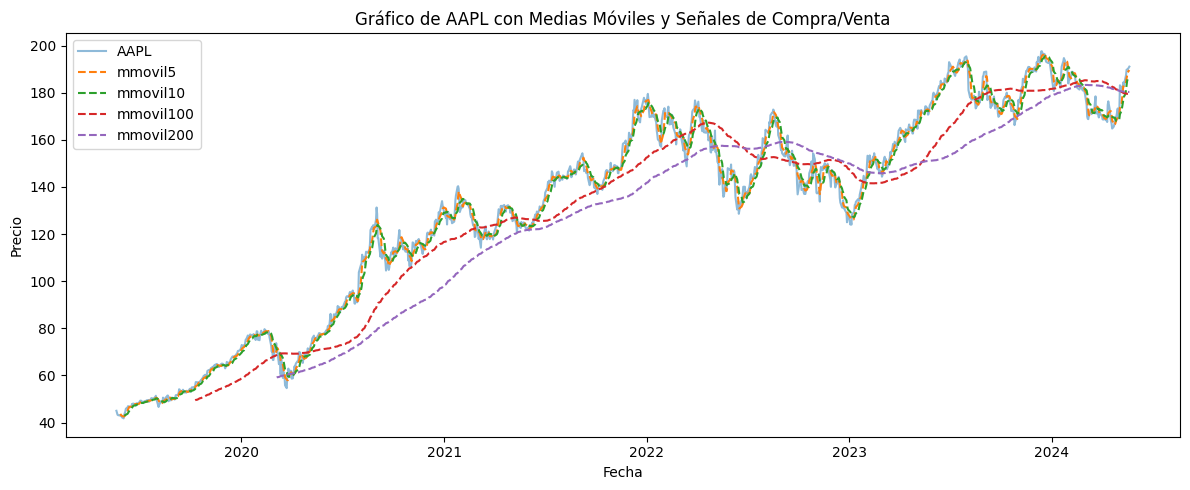

In [ ]:
# Medias Moviles
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(bdatos.index, bdatos[simbolo], label=simbolo, alpha=0.5)
ax.plot(mmoviles.index, mmoviles['mmovil5'], label='mmovil5', linestyle='--')
ax.plot(mmoviles.index, mmoviles['mmovil10'], label='mmovil10', linestyle='--')
ax.plot(mmoviles.index, mmoviles['mmovil100'], label='mmovil100', linestyle='--')
ax.plot(mmoviles.index, mmoviles['mmovil200'], label='mmovil200', linestyle='--')

# Graficar las señales de compra y venta
compra = mmoviles[mmoviles['Señal'] == 'Compra']
venta = mmoviles[mmoviles['Señal'] == 'Venta']
#ax.plot(compra.index, bdatos.loc[compra.index, simbolo], '^', markersize=10, color='g', label='Compra')
#ax.plot(venta.index, bdatos.loc[venta.index, simbolo], 'v', markersize=10, color='r', label='Venta')

ax.set_title(f'Gráfico de {simbolo} con Medias Móviles y Señales de Compra/Venta')
ax.set_xlabel('Fecha')
ax.set_ylabel('Precio')
ax.legend()

# Ajustar el diseño para optimizar el espacio y exportar la figura
plt.tight_layout()
plt.savefig('grafico_mmoviles.png', bbox_inches='tight')


# Guardar la figura en un objeto BytesIO
imgdata_mmoviles = BytesIO()
fig.savefig(imgdata_mmoviles, format='png')
imgdata_mmoviles.seek(0)

img_mmoviles = Image(imgdata_mmoviles)

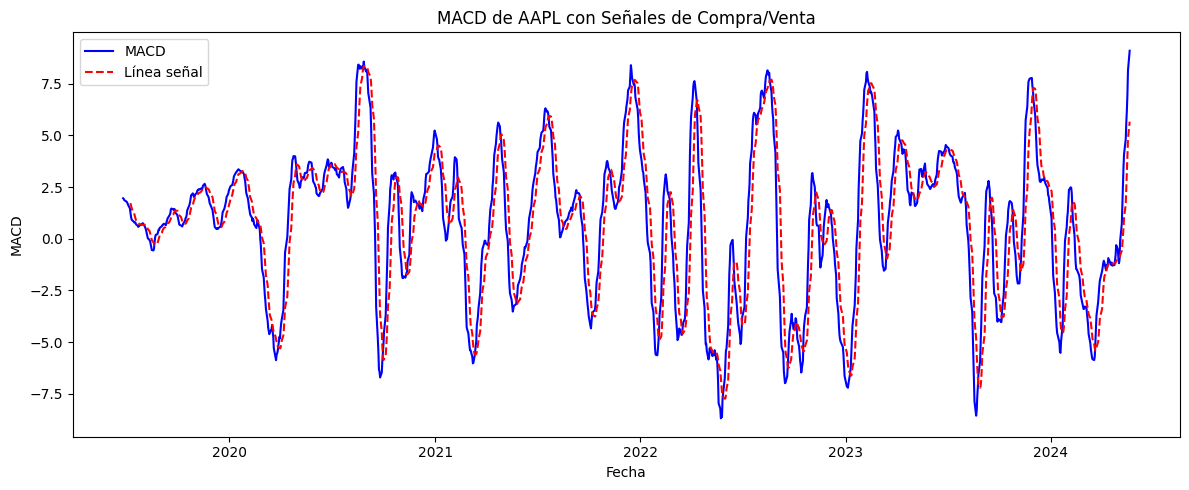

In [ ]:
#MACD

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(bdmacd.index, bdmacd['MACD'], label='MACD', color='b')
ax.plot(bdmacd.index, bdmacd['Linea señal'], label='Línea señal', color='r', linestyle='--')

# Graficar las señales de compra y venta
compra = bdmacd[bdmacd['Señal'] == 'Compra']
venta = bdmacd[bdmacd['Señal'] == 'Venta']
#ax.plot(compra.index, bdmacd.loc[compra.index, 'MACD'], '^', markersize=10, color='g', label='Compra')
#ax.plot(venta.index, bdmacd.loc[venta.index, 'MACD'], 'v', markersize=10, color='r', label='Venta')

ax.set_title(f'MACD de {simbolo} con Señales de Compra/Venta')
ax.set_xlabel('Fecha')
ax.set_ylabel('MACD')
ax.legend()

plt.tight_layout()
plt.savefig('grafico_mmoviles.png', bbox_inches='tight')

# Guardar la figura en un objeto BytesIO
imgdata_macd = BytesIO()
fig.savefig(imgdata_macd, format='png')
imgdata_macd.seek(0)

img_macd = Image(imgdata_macd)

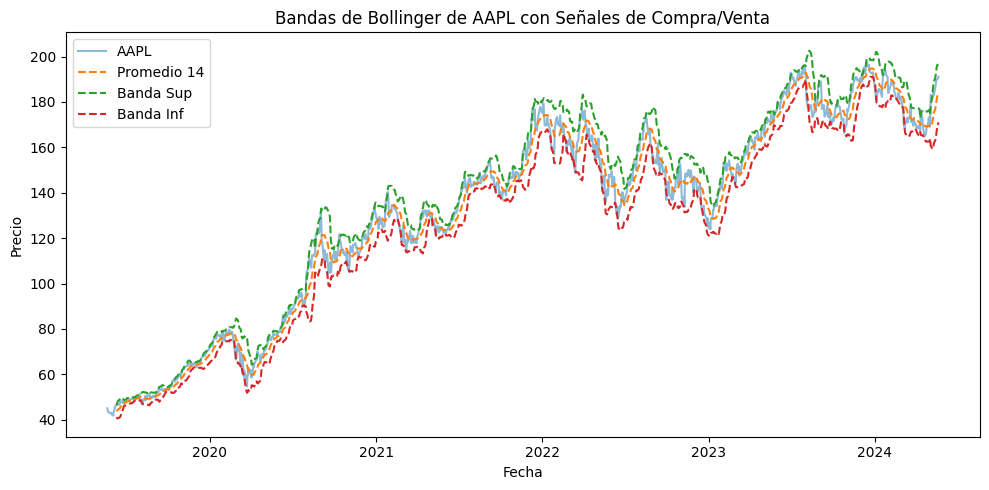

In [ ]:
# Bandas Bollinger

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(bdbollinger.index, bdbollinger[simbolo], label=simbolo, alpha=0.5)
ax.plot(bdbollinger.index, bdbollinger['Promedio 14'], label='Promedio 14', linestyle='--')
ax.plot(bdbollinger.index, bdbollinger['Banda Sup'], label='Banda Sup', linestyle='--')
ax.plot(bdbollinger.index, bdbollinger['Banda Inf'], label='Banda Inf', linestyle='--')

# Graficar las señales de compra y venta
compra = bdbollinger[bdbollinger['Señal'] == 'Compra']
venta = bdbollinger[bdbollinger['Señal'] == 'Venta']
#ax.plot(compra.index, bdbollinger.loc[compra.index, simbolo], '^', markersize=10, color='g', label='Compra')
#ax.plot(venta.index, bdbollinger.loc[venta.index, simbolo], 'v', markersize=10, color='r', label='Venta')

ax.set_title(f'Bandas de Bollinger de {simbolo} con Señales de Compra/Venta')
ax.set_xlabel('Fecha')
ax.set_ylabel('Precio')
ax.legend()

plt.tight_layout()
plt.savefig('grafico_mmoviles.png', bbox_inches='tight')

# Guardar la figura en un objeto BytesIO
imgdata_blger = BytesIO()
fig.savefig(imgdata_blger, format='png')
imgdata_blger.seek(0)

img_blger = Image(imgdata_blger)

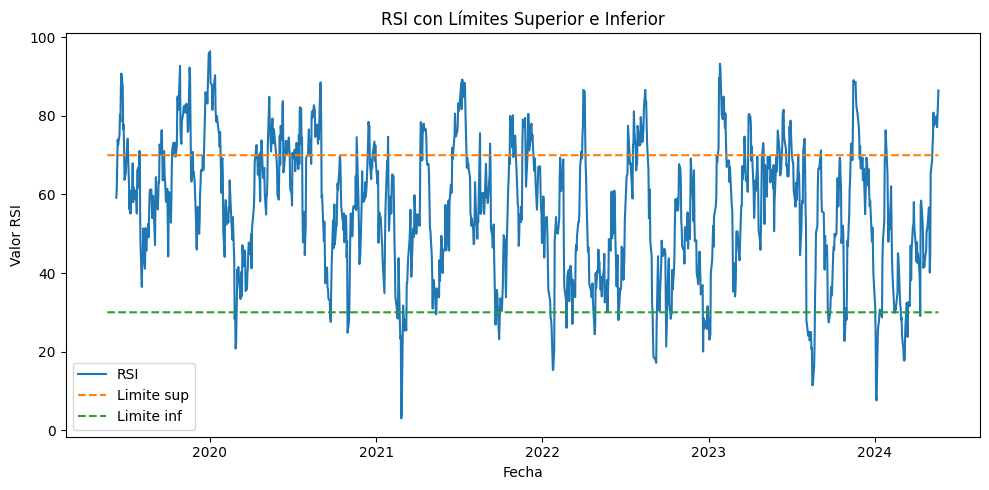

In [ ]:
# RSI

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(bdrsi.index, bdrsi['RSI'], label='RSI')
ax.plot(bdrsi.index, bdrsi['Limite sup'], label='Limite sup', linestyle='--')
ax.plot(bdrsi.index, bdrsi['Limite inf'], label='Limite inf', linestyle='--')

ax.set_title('RSI con Límites Superior e Inferior')
ax.set_xlabel('Fecha')
ax.set_ylabel('Valor RSI')
ax.legend()

plt.tight_layout()
plt.savefig('grafico_mmoviles.png', bbox_inches='tight')

# Guardar la figura en un objeto BytesIO
imgdata_rsi = BytesIO()
fig.savefig(imgdata_rsi, format='png')
imgdata_rsi.seek(0)

img_rsi = Image(imgdata_rsi)


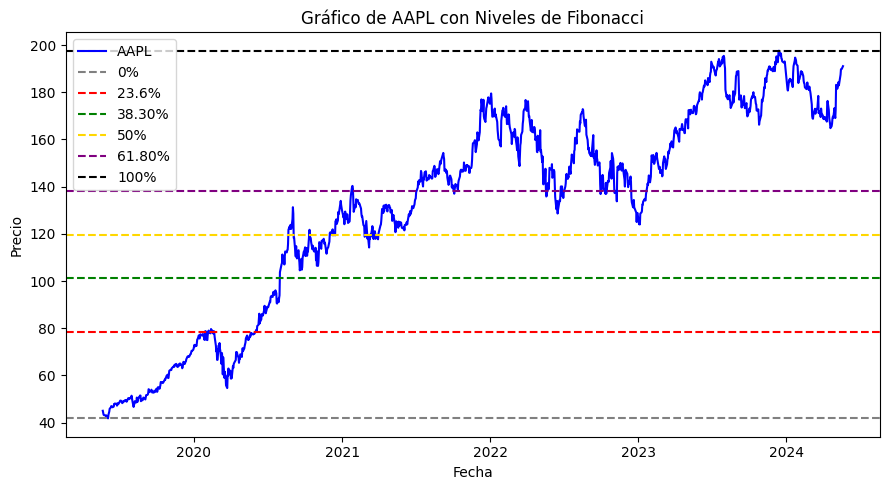

In [ ]:
#Fibonnaci

fig, ax = plt.subplots(figsize=(9, 5))

# Graficar los datos del símbolo
ax.plot(bdfibo3.index, bdfibo3[simbolo], label=simbolo, color='blue')

# Graficar los niveles de Fibonacci
ax.axhline(y=bdfibo3[' 0%'].values[0], color='gray', linestyle='--', label='0%')
ax.axhline(y=bdfibo3[' 23.6%'].values[0], color='red', linestyle='--', label='23.6%')
ax.axhline(y=bdfibo3[' 38.30%'].values[0], color='green', linestyle='--', label='38.30%')
ax.axhline(y=bdfibo3[' 50%'].values[0], color='gold', linestyle='--', label='50%')
ax.axhline(y=bdfibo3[' 61.80%'].values[0], color='purple', linestyle='--', label='61.80%')
ax.axhline(y=bdfibo3[' 100%'].values[0], color='black', linestyle='--', label='100%')

ax.set_title(f'Gráfico de {simbolo} con Niveles de Fibonacci')
ax.set_xlabel('Fecha')
ax.set_ylabel('Precio')
ax.legend()

plt.tight_layout()
plt.savefig('grafico_mmoviles.png', bbox_inches='tight')

# Guardar la figura en un objeto BytesIO
imgdata_fibo = BytesIO()
fig.savefig(imgdata_fibo, format='png')
imgdata_fibo.seek(0)

img_fibo = Image(imgdata_fibo)

##RECOMENDACIONES

In [ ]:
recomendaciones=pd.DataFrame(['Valoracion Estadistica','Valoracion Estadistica','Valoracion Estadistica','Valoracion Tecnica','Valoracion Tecnica','Valoracion Tecnica','Valoracion Tecnica','Valoracion Fundamental','Valoracion Fundamental','Recomendacion Final'], columns=['Tipo de Valoracion'])
recomendaciones['Descripcion']=pd.DataFrame(['Regresion Lineal','Histograma','Percentil','Medias Moviles','Medias Moviles','Medias Moviles','Medias Moviles','Flujo de Caja Descontado','Multiplos',''])
recomendaciones['Recomendacion']=[resumenvstat.iloc[5,3],resumenvstat3.iloc[2,1],resumenvstat4.iloc[2,0],vtecnica.iloc[0,1],vtecnica.iloc[1,1],vtecnica.iloc[2,1],vtecnica.iloc[3,1],valoracionmultiplos.iloc[4,0],fcd.iloc[17,0],'']
recomendaciones['Dato']=""
for i in range(0,len(recomendaciones)):
  if recomendaciones.iloc[i,2]=='Vender':
    recomendaciones.iloc[i,3]=-1
  elif recomendaciones.iloc[i,2]=='Comprar':
    recomendaciones.iloc[i,3]=1
  else:
    recomendaciones.iloc[i,3]=0
recomendaciones['Porcentajes']=[0.2,0.05,0.05,0.075,0.075,0.075,0.075,0.2,0.2,'']
recomendaciones.iloc[9,3]=np.dot(recomendaciones.iloc[:9,3],recomendaciones.iloc[:9,4])
if recomendaciones.iloc[9,3]<0:
  recomendaciones.iloc[9,2]='Vender'
elif recomendaciones.iloc[9,3]>0:
  recomendaciones.iloc[9,2]='Comprar'
else:
  recomendaciones.iloc[9,2]='No hay Señal'
recomendaciones.iloc[9,4]=recomendaciones.iloc[:9,4].sum()

##CIFRAS FINANCIERAS

In [ ]:
ticker_object.income_stmt.loc['Net Income']

2023-09-30    96995000000.0
2022-09-30    99803000000.0
2021-09-30    94680000000.0
2020-09-30    57411000000.0
Name: Net Income, dtype: object

In [ ]:
ticker_object.income_stmt.index

Index(['Tax Effect Of Unusual Items', 'Tax Rate For Calcs',
       'Normalized EBITDA',
       'Net Income From Continuing Operation Net Minority Interest',
       'Reconciled Depreciation', 'Reconciled Cost Of Revenue', 'EBITDA',
       'EBIT', 'Net Interest Income', 'Interest Expense', 'Interest Income',
       'Normalized Income',
       'Net Income From Continuing And Discontinued Operation',
       'Total Expenses', 'Total Operating Income As Reported',
       'Diluted Average Shares', 'Basic Average Shares', 'Diluted EPS',
       'Basic EPS', 'Diluted NI Availto Com Stockholders',
       'Net Income Common Stockholders', 'Net Income',
       'Net Income Including Noncontrolling Interests',
       'Net Income Continuous Operations', 'Tax Provision', 'Pretax Income',
       'Other Income Expense', 'Other Non Operating Income Expenses',
       'Net Non Operating Interest Income Expense',
       'Interest Expense Non Operating', 'Interest Income Non Operating',
       'Operating Inco

In [ ]:
ticker_object.balance_sheet.loc['Total Assets'][0]

352583000000.0

In [ ]:
# Q Tobin
q_tobin = ticker_object.info['marketCap'] / ticker_object.balance_sheet.loc['Total Assets'][0]
#Beta
beta = ticker_object.info['beta']
# UPA 12m
upa = ticker_object.info['trailingEps']
#RPG
rpg = ticker_object.info['currentPrice'] / ticker_object.info['trailingEps']
# Rent_ydt
pcaccion.index = pd.to_datetime(pcaccion.index)
doneee_2024 = pcaccion[pcaccion.index.year == 2024]

if not doneee_2024.empty:
    first_2024_value = doneee_2024.iloc[0]
else:
    first_2024_value = None

rent_ydt = (ticker_object.info['currentPrice'] / first_2024_value)

#ROE
roe = (ticker_object.income_stmt.loc['Net Income'][0] / ticker_object.balance_sheet.loc['Common Stock Equity'][0])
#Ebitda
ebitda = ticker_object.info['ebitda']
#Ebitda%
ebitda_p = ticker_object.info['ebitda'] / ticker_object.info['totalRevenue']
#Cap Bursatil
cap_bursatil = ticker_object.info['sharesOutstanding'] * ticker_object.info['currentPrice']
#EV
ev = ticker_object.info['enterpriseValue']
#EV/Ebitda
ev_ebitda = ticker_object.info['enterpriseValue'] / ticker_object.info['ebitda']
#Relación Deuda
relacion_deuda = ticker_object.info['totalDebt'] / ticker_object.balance_sheet.loc['Total Assets'][0]



# Activo
activo = ticker_object.balance_sheet.loc['Total Assets'][0]
# Pasivo
pasivo = ticker_object.balance_sheet.loc['Total Liabilities Net Minority Interest'][0]
# Patrimonio
patrimonio = ticker_object.balance_sheet.loc['Total Equity Gross Minority Interest'][0]
# Ingresos
ingresos = ticker_object.info['totalRevenue']
# Utilidad Operativa
utilidad_operativa = ticker_object.income_stmt.loc['Operating Income'][0]
# Utilidad Neta
utilidad_neta = ticker_object.income_stmt.loc['Net Income'][0]
# Ebitda 12m
ebitda = ticker_object.info['ebitda']
# Deuda Financiera
deuda_financiera = deudafin.iloc[0][0]



##EXCEL

In [ ]:
# Crear un objeto ExcelWriter
hoja2='Vtecnica'
hoja3='Main'
hoja='Vstat'
nomarchivo='valoracion_'+simbolo


with pd.ExcelWriter(nomarchivo+'.xlsx') as writer:

    ## ANÁLISIS ESTADISTICO

    # Escribir el DataFrame 'bdatoshitograma' en la misma hoja de cálculo, comenzando desde la columna siguiente al final del DataFrame 'bdatios'
    datshisto2.transpose().to_excel(writer, sheet_name=hoja, startcol=bdatos.shape[1]-7,startrow= bdatos.shape[1]+30, index=True)
    bdatoshistograma.to_excel(writer, sheet_name=hoja, startcol=bdatos.shape[1]-7,startrow= bdatos.shape[1]+43, index=False)
    percentil_accion_df.to_excel(writer, sheet_name=hoja, startcol=bdatos.shape[1]+2,startrow= bdatos.shape[1]+43, index=True)

    # Escribir el DataFrame 'tabla_regresion' en la misma hoja de cálculo, comenzando desde la columna siguiente al final del DataFrame 'bdatoshitograma'
    tabla_regresion.transpose().to_excel(writer, sheet_name=hoja, startcol=bdatos.shape[1]-7, startrow= bdatos.shape[1]+14, index=True)


    ## ANÁLISIS FUNDAMENTAL
    # Valoración multiplos
    multiplos.to_excel(writer, sheet_name=hoja, startcol=bdatos.shape[1]+8, startrow= bdatos.shape[1]+31, index=True)

    # CAPEX
    cuentasfcl.to_excel(writer, sheet_name=hoja, startcol=cuentasfcl.shape[1]+14, startrow= bdatos.shape[1]+43, index=True)

    # WACC
    wacc.to_excel(writer, sheet_name=hoja, startcol=cuentasfcl.shape[1]+19, startrow= bdatos.shape[1]+43, index=True)

    # Flujo de Caja Libre
    fcl.to_excel(writer, sheet_name=hoja, startcol=cuentasfcl.shape[1]+14, startrow= bdatos.shape[1]+65, index=True)



    ## ANÁLISIS TÉCNICO

    #Fibonacci
    bdfibo.to_excel(writer, sheet_name=hoja, startcol=bdatos.shape[1]+33,startrow= bdatos.shape[1]+72, index=False)


    # Escribir el DataFrame 'bdatios' en la hoja2 de cálculo
    mmoviles.to_excel(writer, sheet_name=hoja2, index=True)

    # Escribir el DataFrame 'bdatoshitograma' en la misma hoja2 de cálculo, comenzando desde la columna siguiente al final del DataFrame 'bdatios'
    bdmacd.to_excel(writer, sheet_name=hoja2, startcol=mmoviles.shape[1]+2, index=True)
    bdrsi.to_excel(writer, sheet_name=hoja2, startcol=mmoviles.shape[1]+9, index=True)
    bdbollinger.to_excel(writer, sheet_name=hoja2, startcol=mmoviles.shape[1]+20, index=True)
    bdfibo2.to_excel(writer, sheet_name=hoja2, startcol=bdatos.shape[1]+21,startrow= bdatos.shape[1]+30, index=True)
    bdfibo.to_excel(writer, sheet_name=hoja2, startcol=bdatos.shape[1]+31, index=False)

    ## RECOMENDACIONES
    recomendaciones.to_excel(writer, sheet_name=hoja,startcol=bdatos.shape[1]+57,startrow= bdatos.shape[1]+10, index=False)

    resumenvstat.to_excel(writer, sheet_name=hoja, startcol=bdatos.shape[1]+57,startrow= bdatos.shape[1]+24, index=True)

    resumenvstat2.to_excel(writer, sheet_name=hoja, startcol=bdatos.shape[1]+57,startrow= bdatos.shape[1]+33, index=True)

    resumenvstat3.to_excel(writer, sheet_name=hoja, startcol=bdatos.shape[1]+57,startrow= bdatos.shape[1]+40, index=True)

    resumenvstat4.to_excel(writer, sheet_name=hoja, startcol=bdatos.shape[1]+57,startrow= bdatos.shape[1]+47, index=True)

    vtecnica.to_excel(writer, sheet_name=hoja, startcol=bdatos.shape[1]+57,startrow= bdatos.shape[1]+54, index=True)

    fcd.to_excel(writer, sheet_name=hoja, startcol=bdatos.shape[1]+57,startrow= bdatos.shape[1]+63, index=True)

    valoracionmultiplos.to_excel(writer, sheet_name=hoja, startcol=bdatos.shape[1]+57,startrow= bdatos.shape[1]+85, index=True)

    #Tabla de datos
    bdatos.to_excel(writer, sheet_name=hoja3, startcol=bdatos.shape[1]-8, startrow= bdatos.shape[1]-8, index=True)
    ticker_object.balance_sheet.to_excel(writer, sheet_name=hoja3, startcol=bdatos.shape[1]+6, startrow= bdatos.shape[1]-8, index=True)
    ticker_object.income_stmt.to_excel(writer, sheet_name=hoja3, startcol=bdatos.shape[1]+16, startrow= bdatos.shape[1]-8, index=True)


# Información de la empresa
wb = load_workbook(nomarchivo + '.xlsx')
ws1 = wb[hoja]
#ws2 = wb[hoja2]

ws1['B7'] = 'Información de la empresa'
ws1['B10'] = 'Ticker'
ws1['B11'] = 'FI'
ws1['B12'] = 'FF'
ws1['B13'] = 'Nombre'
ws1['F10'] = 'Sector'
ws1['F11'] = 'Industria'
ws1['J10'] = 'Comparable'

translator = Translator()
#Traducción palabra sector
try:
  palabra_sector = translator.translate(ticker_object.info['sector'], src='en', dest='es')
  traduccion_sector = palabra_sector.text
except:
  traduccion_sector = 'N/A'


#Traducción palabra sector
try:
  palabra_industria = translator.translate(ticker_object.info['industry'], src='en', dest='es')
  traduccion_industria = palabra_industria.text
except:
  traduccion_industria = 'N/A'

ws1['C10'] = simbolo = ticker_object.info['symbol']
ws1['C11'] = finicio
ws1['C12'] = ffin
ws1['C13'] = simbolo = ticker_object.info['longName']
ws1['G10'] = traduccion_sector
ws1['G11'] = traduccion_industria
ws1['K10'] = simbolo2

ws1['B16'] = 'Análisis Estadistico'
ws1['B19'] = 'Variable Dependiente Y'
ws1['B20'] = 'Variable Independiente X'
ws1['E19'] = 'Cierre Y en LN '
ws1['E20'] = 'Cierre X en LN'
ws1['H19'] = 'Cierre Y'
ws1['H20'] = 'Cierre X'

ws1['C19'] = simbolo = ticker_object.info['symbol']
ws1['C20'] = simbolo2
ws1['F19'] = bdatos['LNR1'].iloc[-1]
ws1['F20'] = bdatos['LNR2'].iloc[-1]
ws1['I19'] = np.exp(bdatos['LNR1'].iloc[-1])
ws1['I20'] = np.exp(bdatos['LNR2'].iloc[-1])


ws1['B37'] = 'Analisis Historico'

# Análisis Fundamental

ws1['Q16'] = 'Análisis Fundamental'

ws1['Q37'] = 'Multiplos Financieros'

ws1['Q49'] = 'CAPEX'

ws1['V49'] = 'WACC'

ws1['Q71'] = 'Flujo de Caja Libre'





# Análisis Técnico

ws1['AC16'] = 'Análisis Técnico I'
ws1['AP75'] = 'Calculo Fibonacci'
ws1['AP76'] = 'Precio Max.'
ws1['AP77'] = 'Precio Min.'
ws1['AP79'] = 'Rango'

## Fibonacci
ws1['AQ76'] = pcaccion.max()
ws1['AQ77'] = pcaccion.min()
ws1['AQ79'] = pcaccion.max() - pcaccion.min()


ws1['AW16'] = 'Análisis Técnico II'
ws1['AW40'] = 'Sobrecompra'
ws1['AW41'] = 'Sobreventa'
ws1['AX40'] = limitesuprsi
ws1['AX41'] = limiteinfrsi

ws1.add_image(img_rsi, 'AW47')
ws1.add_image(img_mmoviles, 'AC19')
ws1.add_image(img_blger, 'AW19')
ws1.add_image(img_macd, 'AC47')
ws1.add_image(img_fibo, 'AC75')


# Señales
ws1['BN16'] = 'Señales Consolidadas'

# Cifras financieras
ws1['BW16'] = 'Resumen de Cifras Financieras'
ws1['BW19'] = 'Q-Tobin'
ws1['BW20'] = 'Beta'
ws1['BW21'] = 'UPA Ult. 12m'
ws1['BW22'] = 'RPG Ult. 12m'
ws1['BW23'] = 'Rent. YDT'
ws1['BW24'] = 'ROE Ult. 12m'
ws1['BW25'] = 'Ebitda 12m'
ws1['BW26'] = 'Ebitda (%) 12m'
ws1['BW27'] = 'Cap. Bursátil'
ws1['BW28'] = 'EV'
ws1['BW29'] = 'EV/Ebitda'
ws1['BW30'] = 'Relación Deuda'

ws1['BW33'] = 'Cuenta'
ws1['BW34'] = 'Activo'
ws1['BW35'] = 'Pasivo'
ws1['BW36'] = 'Patrimonio'
ws1['BW37'] = 'Ingresos'
ws1['BW38'] = 'Util. Operativa'
ws1['BW39'] = 'Util. Neta'
ws1['BW40'] = 'Ebitda 12m'
ws1['BW41'] = 'Deuda Financiera'


ws1['BX33'] = 'Valor'
ws1['BX19'] = q_tobin
ws1['BX20'] = beta
ws1['BX21'] = upa
ws1['BX22'] = rpg
ws1['BX23'] = rent_ydt
ws1['BX24'] = roe
ws1['BX25'] = ebitda
ws1['BX26'] = ebitda_p
ws1['BX27'] = cap_bursatil
ws1['BX28'] = ev
ws1['BX29'] = ev_ebitda
ws1['BX30'] = relacion_deuda


ws1['BX34'] = activo
ws1['BX35'] = pasivo
ws1['BX36'] = patrimonio
ws1['BX37'] = ingresos
ws1['BX38'] = utilidad_operativa
ws1['BX39'] = utilidad_neta
ws1['BX40'] = ebitda
ws1['BX41'] = deuda_financiera


ws1['BY33'] = 'Variación Anual'
ws1['BY34'] = ((activo - ticker_object.balance_sheet.loc['Total Assets'][1])/ ticker_object.balance_sheet.loc['Total Assets'][1])
ws1['BY35'] = ((pasivo - ticker_object.balance_sheet.loc['Total Liabilities Net Minority Interest'][1])/ ticker_object.balance_sheet.loc['Total Liabilities Net Minority Interest'][1])
ws1['BY36'] = ((patrimonio - ticker_object.balance_sheet.loc['Total Equity Gross Minority Interest'][1])/ticker_object.balance_sheet.loc['Total Equity Gross Minority Interest'][1])
ws1['BY37'] = ((ingresos - ticker_object.income_stmt.loc['Operating Revenue'][1])/ ticker_object.income_stmt.loc['Operating Revenue'][1])
ws1['BY38'] = ((utilidad_operativa - ticker_object.income_stmt.loc['Operating Income'][1])/ ticker_object.income_stmt.loc['Operating Income'][1])
ws1['BY39'] = ((utilidad_neta - ticker_object.income_stmt.loc['Net Income'][1])/ ticker_object.income_stmt.loc['Net Income'][1])
ws1['BY40'] = ((ticker_object.income_stmt.loc['EBITDA'][0] - ticker_object.income_stmt.loc['EBITDA'][1])/ ticker_object.income_stmt.loc['EBITDA'][1])
ws1['BY41'] = ((deuda_financiera - deudafin.iloc[0][1]) / deudafin.iloc[0][1])


# Guardar los cambios en el archivo
wb.save(nomarchivo + '.xlsx')


files.download(nomarchivo+'.xlsx')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>